In [1]:
import os
import json
import numpy as np

# Strategy:
# Extract pos_ner + embeddings & rolling embeddings
# Flag bad ner, use POS to get the numbers and potential other bad stuff
# Project embeddings & rolling embeddings, cosine sim with all other clusters ?
# Then rules for numbers

text_path = '../example_conversations/english/labelled_text_conv_1.json'

with open(text_path, 'r') as f:
    labelled_data = json.load(f)

unlabelled_data = [list(i.keys())[0] for i in labelled_data]


In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

MODEL_ID = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
MODEL_ID = 'google/gemma-3-1b-it'

MODEL_ID = 'google/gemma-3-4b-it-qat-q4_0-gguf'

MODEL_ID = 'vinimuchulski/gemma-3-4b-it-qat-q4_0-gguf'
MODEL_ID = 'google/gemma-3-12b-it'
# MODEL_ID = 'meta-llama/Llama-3.2-1B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID)

def call_llm(prompt: str, max_tokens=10):

    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=max_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))



Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
call_llm('Hello, who are you ?')

Hello, who are you ?

Hello! I'm Gemma, an open


In [5]:
def call_llm(prompt: str, max_tokens=10):

    inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=max_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [6]:
with open('../prompt.txt', 'r') as f:
    prompt = f.read()

rolled_window_data = []
win_down, win_up = -5, 5
for idx, word in enumerate(unlabelled_data):
    start, end = idx + win_down, idx + win_up
    start = max(0, start)
    end = min(end, len(unlabelled_data))

    rolled_window_data.append((' '.join(unlabelled_data[start:end]), word, idx))

rolled_window_data

[('Hi can you believe the', 'Hi', 0),
 ('Hi can you believe the bus', 'can', 1),
 ('Hi can you believe the bus was', 'you', 2),
 ('Hi can you believe the bus was late', 'believe', 3),
 ('Hi can you believe the bus was late again', 'the', 4),
 ('Hi can you believe the bus was late again this', 'bus', 5),
 ('can you believe the bus was late again this morning', 'was', 6),
 ('you believe the bus was late again this morning Yeah', 'late', 7),
 ('believe the bus was late again this morning Yeah it’s', 'again', 8),
 ('the bus was late again this morning Yeah it’s always', 'this', 9),
 ('bus was late again this morning Yeah it’s always Line', 'morning', 10),
 ('was late again this morning Yeah it’s always Line 25', 'Yeah', 11),
 ('late again this morning Yeah it’s always Line 25 I', 'it’s', 12),
 ('again this morning Yeah it’s always Line 25 I was', 'always', 13),
 ('this morning Yeah it’s always Line 25 I was supposed', 'Line', 14),
 ('morning Yeah it’s always Line 25 I was supposed to', '25

In [7]:
def inject_prompt(sentence, word):

    return prompt.replace('$sentence$', sentence).replace('$word$', word)

sentence, word = rolled_window_data[378][:2]

injected_prompt = inject_prompt(sentence.lower(), word.lower())

print(injected_prompt)

Task: You are a de-identification model. Your job is to classify a target word from a sentence as either safe to publish (0) or sensitive personal information (1) according to the HIPAA Privacy Rule.

The HIPAA rule defines 18 types of sensitive information. If the word is part of any of these identifiers, label it as 1 (sensitive). Otherwise, label it as 0 (safe).

HIPAA identifiers include:
- Names
- Addresses smaller than a state (e.g. street, city, ZIP)
- Dates (except year)
- Phone/fax numbers
- Email addresses
- Social Security numbers
- Medical record / account / license numbers
- Vehicle / device IDs
- URLs / IP addresses
- Fingerprints / voiceprints
- Photos / any other unique identifying detail

Answer with just one digit:
- 1 = sensitive
- 0 = safe

Examples:

Sentence: My name is John Smith and I live in Geneva.
Word: John
Answer: 1

Sentence: My name is John Smith and I live in Geneva.
Word: Geneva
Answer: 1

Sentence: My name is John Smith and I live in Geneva.
Word: live

In [8]:
response = call_llm(injected_prompt, 2)

response[-5:]

'er: 0'

In [10]:
labelled_data = []

for sentence, word, idx in rolled_window_data:
    injected_prompt = inject_prompt(sentence, word)

    response = call_llm(injected_prompt, 2)[-3:]
    labelled_data.append((word, response))

    print(idx+1, '/385')

for w, l in labelled_data:

    code = 32 if l[-1] == '0' else 31
    print(f'\033[{code}m {w} \033[0m', end='')

1 /385
2 /385
3 /385
4 /385
5 /385
6 /385
7 /385
8 /385
9 /385
10 /385
11 /385
12 /385
13 /385
14 /385
15 /385
16 /385
17 /385
18 /385
19 /385
20 /385
21 /385
22 /385
23 /385
24 /385
25 /385
26 /385
27 /385
28 /385
29 /385
30 /385
31 /385
32 /385
33 /385
34 /385
35 /385
36 /385
37 /385
38 /385
39 /385
40 /385
41 /385
42 /385
43 /385
44 /385
45 /385
46 /385
47 /385
48 /385
49 /385
50 /385
51 /385
52 /385
53 /385
54 /385
55 /385
56 /385
57 /385
58 /385
59 /385
60 /385
61 /385
62 /385
63 /385
64 /385
65 /385
66 /385
67 /385
68 /385
69 /385
70 /385
71 /385
72 /385
73 /385
74 /385
75 /385
76 /385
77 /385
78 /385
79 /385
80 /385
81 /385
82 /385
83 /385
84 /385
85 /385
86 /385
87 /385
88 /385
89 /385
90 /385
91 /385
92 /385
93 /385
94 /385
95 /385
96 /385
97 /385
98 /385
99 /385
100 /385
101 /385
102 /385
103 /385
104 /385
105 /385
106 /385
107 /385
108 /385
109 /385
110 /385
111 /385
112 /385
113 /385
114 /385
115 /385
116 /385
117 /385
118 /385
119 /385
120 /385
121 /385
122 /385
123 /385
1

In [11]:
import json

with open('../example_conversations/english/labelled_text_conv_1.json', 'r') as f:
    ground_truth = json.loads(f.read())

ground_truth

[{'Hi': 0},
 {'can': 0},
 {'you': 0},
 {'believe': 0},
 {'the': 0},
 {'bus': 0},
 {'was': 0},
 {'late': 0},
 {'again': 0},
 {'this': 0},
 {'morning': 0},
 {'Yeah': 0},
 {'it’s': 0},
 {'always': 0},
 {'Line': 1},
 {'25': 1},
 {'I': 0},
 {'was': 0},
 {'supposed': 0},
 {'to': 0},
 {'be': 0},
 {'at': 0},
 {'4': 1},
 {'Place': 1},
 {'du': 1},
 {'Marché': 1},
 {'by': 0},
 {'8h30': 0},
 {'Did': 0},
 {'you': 0},
 {'see': 0},
 {'that': 0},
 {'new': 0},
 {'café': 0},
 {'on': 0},
 {'Rue': 1},
 {'de': 1},
 {'la': 1},
 {'Paix': 1},
 {'No': 0},
 {'but': 0},
 {'Clara': 1},
 {'mentioned': 0},
 {'it': 0},
 {'to': 0},
 {'me': 0},
 {'Speaking': 0},
 {'of': 0},
 {'Clara’s': 1},
 {'birthday': 0},
 {'is': 0},
 {'on': 0},
 {'March': 1},
 {'18th': 1},
 {'right': 0},
 {'Yes': 0},
 {'but': 0},
 {'she’s': 0},
 {'having': 0},
 {'the': 0},
 {'party': 0},
 {'next': 0},
 {'Friday': 1},
 {'at': 0},
 {'her': 0},
 {'place': 0},
 {'in': 0},
 {'Lausanne': 1},
 {'I’ll': 0},
 {'need': 0},
 {'to': 0},
 {'check': 0},
 {'with

In [18]:
true_labels = [int(list(v.values())[0]) for v in ground_truth]
test_labels = [int(i[1][-1]) for i in labelled_data]

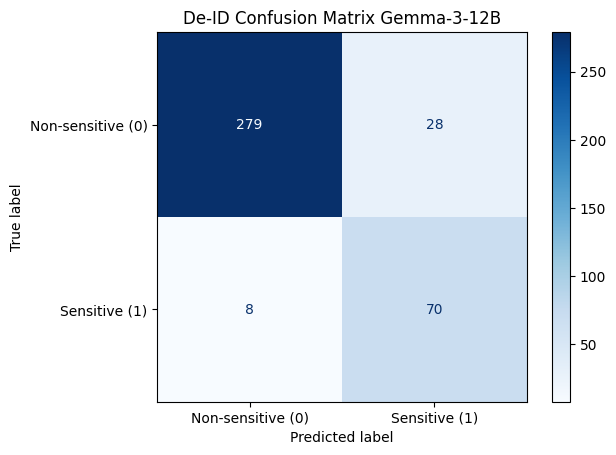

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-sensitive (0)', 'Sensitive (1)'])
disp.plot(cmap='Blues')
plt.title('De-ID Confusion Matrix Gemma-3-12B')
plt.show()

In [32]:
def print_colored_text(labelled_data, true_data):
    # ANSI codes
    GREEN = '\033[92m'
    RED   = '\033[91m'
    BLUE  = '\033[94m'
    END   = '\033[0m'

    for i in range(len(labelled_data)):

        word = labelled_data[i][0]
        pred_label = int(labelled_data[i][1][-1])
        true_label = true_data[i]

        if true_label == 1 and pred_label == 1:
            # True positive (hit): green
            code = GREEN
        elif true_label == 0 and pred_label == 1:
            # False positive: blue
            code = BLUE
        elif true_label == 1 and pred_label == 0:
            # False negative: red
            code = RED
        else:
            code = GREEN

        print(f'{code}{word}\033[0m', end=' ')

print_colored_text(labelled_data, true_labels)


Hi can you believe the bus was late again this morning Yeah it’s always Line 25 I was supposed to be at 4 Place du Marché by 8h30 Did you see that new café on Rue de la Paix No but Clara mentioned it to me Speaking of Clara’s birthday is on March 18th right Yes but she’s having the party next Friday at her place in Lausanne I’ll need to check with my wife Emma if we’re free that night You can just text me at 079 321 56 78 if anything changes Sure thing By the way did you send your forms to Dr Feller yet Not yet I lost the envelope with my patient ID I think it’s 651384 I’m always losing stuff Haha same Last week I forgot my son’s medical appointment on the 12th Where was it At Hôpital de la Tour Avenue J-D Maillard 3 Meyrin That’s far from your place in Versoix Tell me about it At least the weather was nice My cousin is moving to Zürich next month Do you have her new address Not yet but her old one was 45 Hauptstrasse Winterthur I just got a new phone number finally Swiss 078 945 31 62

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
